In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets.ascad import AscadDataset
from models.recurrent import LstmModel
from models.effcnn import EffCnn_N0
from datasets.transforms import ToTensor, ToLabelTensor
from training.training import execute_epoch, train_batch, eval_batch
from training.metrics import get_loss, get_accuracy, get_mean_rank, get_rank_over_time

In [2]:
retrain = False
retrain_disc = False
num_epochs = 10
batch_size = 256
grad_clip_norm = 1.0
metrics = {'loss': get_loss}
results_dir = os.path.join('.', 'results', 'lstm_autoencoder')

In [3]:
train_dataset = AscadDataset(train=True, transform=ToTensor(), target_transform=ToLabelTensor())
test_dataset = AscadDataset(train=False, transform=ToTensor(), target_transform=ToLabelTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
realistic_hindsight_values = [True, False]
delay_values = [0, 1, 2, 4, 8, 16]
train_results = {(hs, d): {} for hs in realistic_hindsight_values for d in delay_values}
test_results = {(hs, d): {} for hs in realistic_hindsight_values for d in delay_values}

if retrain:
    for realistic_hindsight in realistic_hindsight_values:
        for delay in delay_values:
            model = LstmModel(delay=delay, realistic_hindsight=realistic_hindsight)
            loss_fn = nn.MSELoss()
            optimizer = optim.Adam(model.parameters())
            device = 'cuda'
            model = model.to(device)
            print('Realistic hindsight: {}, Delay: {}'.format(realistic_hindsight, delay))

            def train_epoch(update_params=True):
                if update_params:
                    results = execute_epoch(train_batch, train_dataloader, model, loss_fn, optimizer, device,
                                            batch_metric_fns=metrics, autoencoder=True, grad_clip_val=1.0)
                else:
                    results = execute_epoch(eval_batch, train_dataloader, model, loss_fn, device,
                                            batch_metric_fns=metrics, autoencoder=True)
                for key in results.keys():
                    if not(key in train_results[(realistic_hindsight, delay)].keys()):
                        train_results[(realistic_hindsight, delay)][key] = []
                    train_results[(realistic_hindsight, delay)][key].append(results[key])


            def test_epoch():
                results = execute_epoch(eval_batch, test_dataloader, model, loss_fn, device,
                                        batch_metric_fns=metrics, autoencoder=True)
                for key in results.keys():
                    if not(key in test_results[(realistic_hindsight, delay)].keys()):
                        test_results[(realistic_hindsight, delay)][key] = []
                    test_results[(realistic_hindsight, delay)][key].append(results[key])

            #train_epoch(update_params=False)
            test_epoch()
            for epoch in tqdm(range(num_epochs)):
                train_epoch()
                test_epoch()
            torch.save(model, os.path.join(results_dir, 'trained_model__{}_{}.pt'.format(realistic_hindsight, delay)))

In [5]:
if retrain:
    with open(os.path.join(results_dir, 'train_results.pickle'), 'wb') as F:
        pickle.dump(train_results, F)
    with open(os.path.join(results_dir, 'test_results.pickle'), 'wb') as F:
        pickle.dump(test_results, F)

In [12]:
with open(os.path.join(results_dir, 'train_results.pickle'), 'rb') as F:
    train_results = pickle.load(F)
with open(os.path.join(results_dir, 'test_results.pickle'), 'rb') as F:
    test_results = pickle.load(F)

In [7]:
from torch.optim.lr_scheduler import OneCycleLR

disc_train_results = {(hs, d): {} for hs in realistic_hindsight_values for d in delay_values}
disc_test_results = {(hs, d): {} for hs in realistic_hindsight_values for d in delay_values}
disc_train_results['baseline'] = {}
disc_test_results['baseline'] = {}
batch_metrics = {'loss': get_loss, 'acc': get_accuracy, 'mnrk': get_mean_rank}
epoch_metrics = {}#{'rot': get_rank_over_time}
num_epochs = 150

if retrain_disc:
    
    discriminator_model = EffCnn_N0(train_dataset.input_shape)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-5)
    lr_manager = OneCycleLR(optimizer, 1e-3, epochs=num_epochs, steps_per_epoch=len(train_dataloader))
    device = 'cuda'
    discriminator_model = discriminator_model.to(device)
    print('Baseline')

    def train_epoch(update_params=True):
        if update_params:
            results = execute_epoch(train_batch, train_dataloader, discriminator_model, loss_fn, optimizer, device, lr_manager=lr_manager,
                                    batch_metric_fns=batch_metrics, epoch_metric_fns=epoch_metrics)
        else:
            results = execute_epoch(eval_batch, train_dataloader, discriminator_model, loss_fn, device,
                                    batch_metric_fns=batch_metrics, epoch_metric_fns=epoch_metrics)
        for key in results.keys():
            if not(key in disc_train_results['baseline'].keys()):
                disc_train_results['baseline'][key] = []
            disc_train_results['baseline'][key].append(results[key])

    def test_epoch():
        pass
#        results = execute_epoch(eval_batch, test_dataloader, discriminator_model, loss_fn, device,
#                                batch_metric_fns=batch_metrics, epoch_metric_fns=epoch_metrics)
#        for key in results.keys():
#            if not(key in disc_test_results['baseline'].keys()):
#                disc_test_results['baseline'][key] = []
#            disc_test_results['baseline'][key].append(results[key])

    train_epoch(update_params=False)
    test_epoch()
    for epoch in tqdm(range(num_epochs)):
        train_epoch()
        test_epoch()
    torch.save(discriminator_model, os.path.join(results_dir, 'trained_disc__baseline.pt'))
    
    for realistic_hindsight in [True]:#realistic_hindsight_values:
        for delay in delay_values:
            generator_model = torch.load(os.path.join(results_dir, 'trained_model__{}_{}.pt'.format(realistic_hindsight, delay)))
            generator_model.requires_grad = False
            discriminator_model = EffCnn_N0(train_dataset.input_shape)
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-5)
            lr_manager = OneCycleLR(optimizer, 1e-3, epochs=num_epochs, steps_per_epoch=len(train_dataloader))
            device = 'cuda'
            generator_model = generator_model.to(device)
            discriminator_model = discriminator_model.to(device)
            print('Realistic hindsight: {}, Delay: {}'.format(realistic_hindsight, delay))

            def train_epoch(update_params=True):
                if update_params:
                    results = execute_epoch(train_batch, train_dataloader, discriminator_model, loss_fn, optimizer, device, lr_manager=lr_manager,
                                            batch_metric_fns=batch_metrics, epoch_metric_fns=epoch_metrics, generator=generator_model)
                else:
                    results = execute_epoch(eval_batch, train_dataloader, discriminator_model, loss_fn, device,
                                            batch_metric_fns=batch_metrics, epoch_metric_fns=epoch_metrics, generator=generator_model)
                for key in results.keys():
                    if not(key in disc_train_results[(realistic_hindsight, delay)].keys()):
                        disc_train_results[(realistic_hindsight, delay)][key] = []
                    disc_train_results[(realistic_hindsight, delay)][key].append(results[key])


            def test_epoch():
                pass
                #results = execute_epoch(eval_batch, test_dataloader, discriminator_model, loss_fn, device,
                #                        batch_metric_fns=batch_metrics, epoch_metric_fns=epoch_metrics, generator=generator_model)
                #for key in results.keys():
                #    if not(key in disc_test_results[(realistic_hindsight, delay)].keys()):
                #        disc_test_results[(realistic_hindsight, delay)][key] = []
                #    disc_test_results[(realistic_hindsight, delay)][key].append(results[key])

            train_epoch(update_params=False)
            test_epoch()
            for epoch in tqdm(range(num_epochs)):
                train_epoch()
                test_epoch()
            torch.save(discriminator_model, os.path.join(results_dir, 'trained_disc__{}_{}.pt'.format(realistic_hindsight, delay)))

In [8]:
if retrain_disc:
    with open(os.path.join(results_dir, 'disc_train_results.pickle'), 'wb') as F:
        pickle.dump(disc_train_results, F)
    with open(os.path.join(results_dir, 'disc_test_results.pickle'), 'wb') as F:
        pickle.dump(disc_test_results, F)

In [9]:
with open(os.path.join(results_dir, 'disc_train_results.pickle'), 'rb') as F:
    disc_train_results = pickle.load(F)
with open(os.path.join(results_dir, 'disc_test_results.pickle'), 'rb') as F:
    disc_test_results = pickle.load(F)

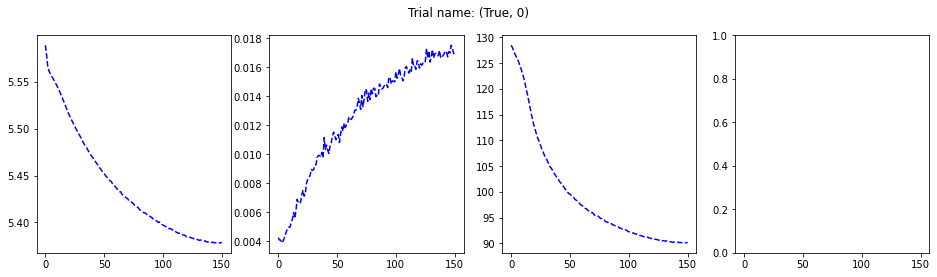

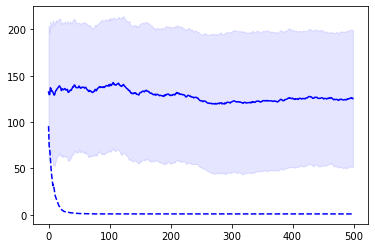

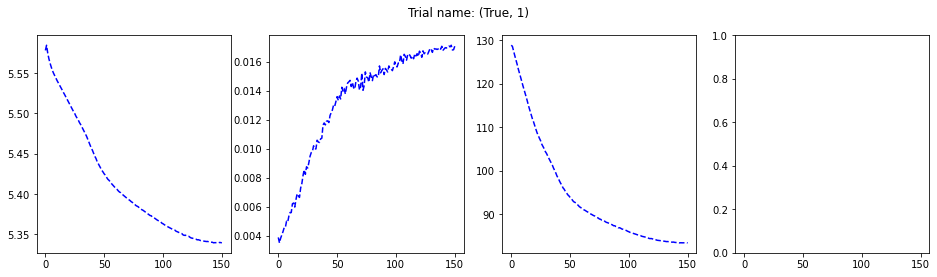

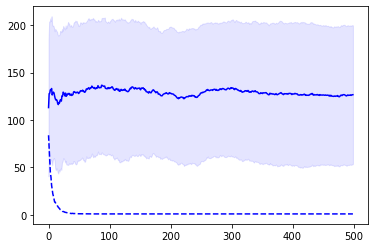

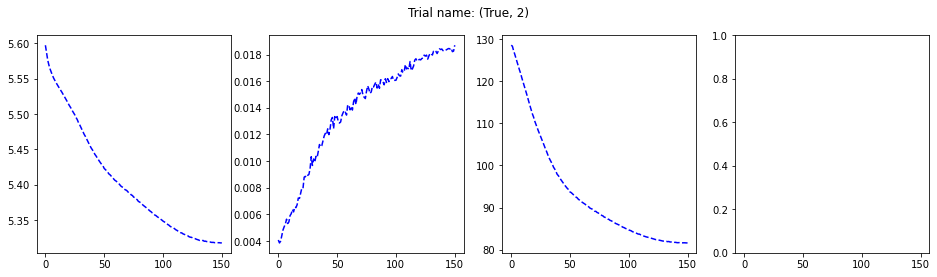

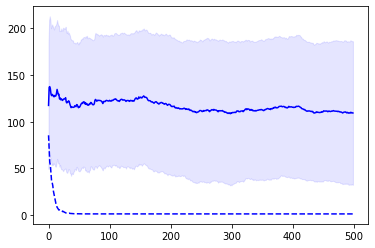

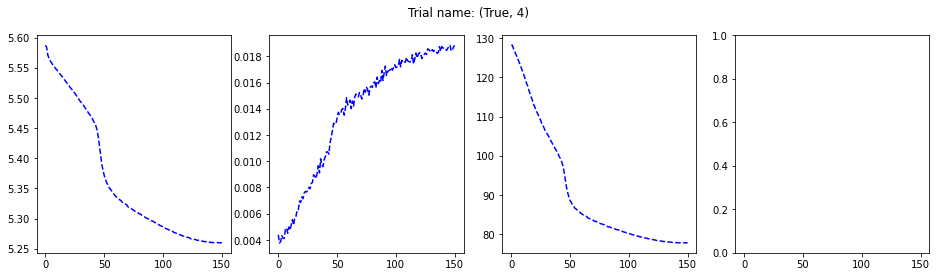

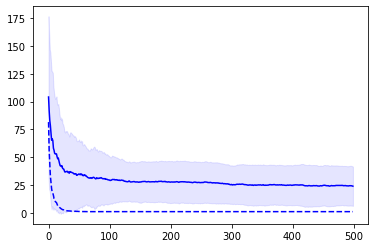

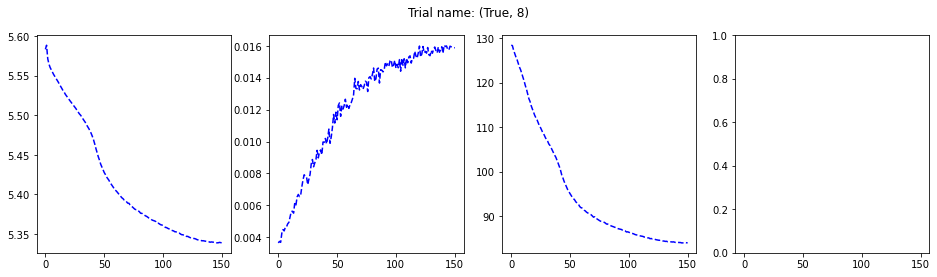

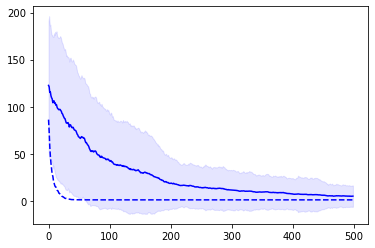

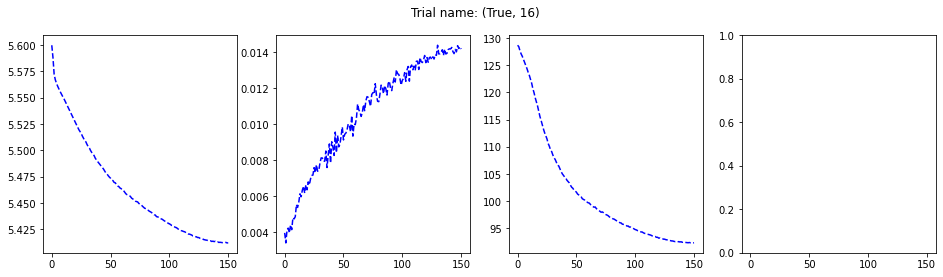

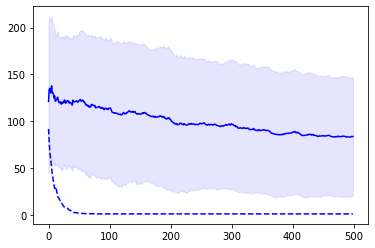

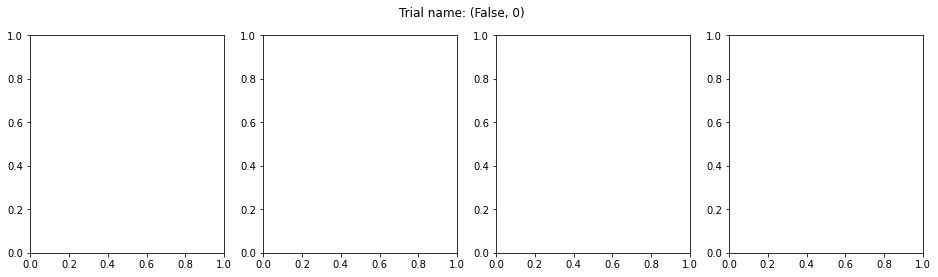

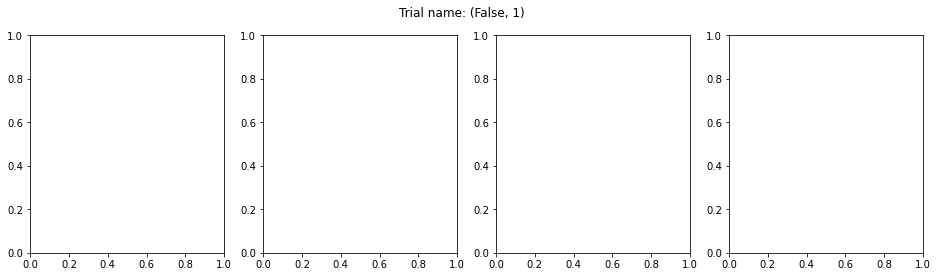

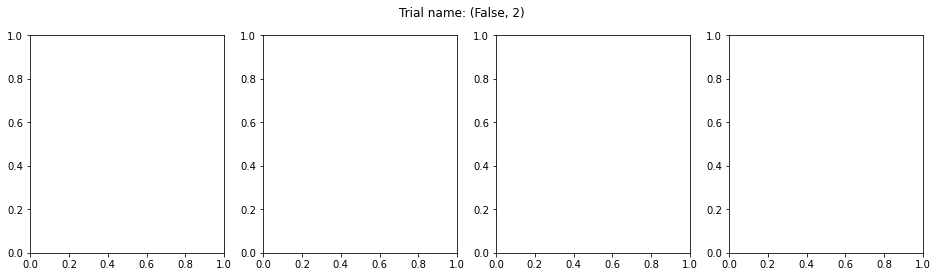

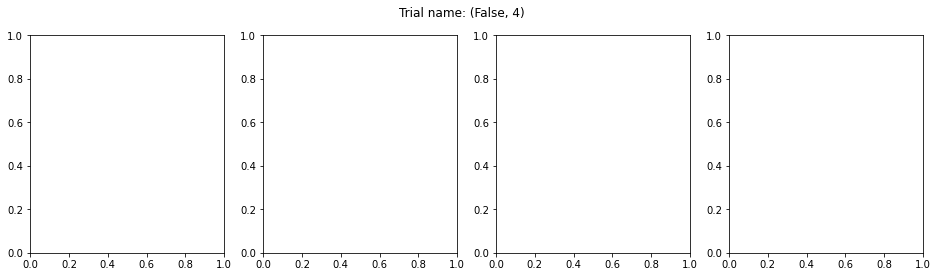

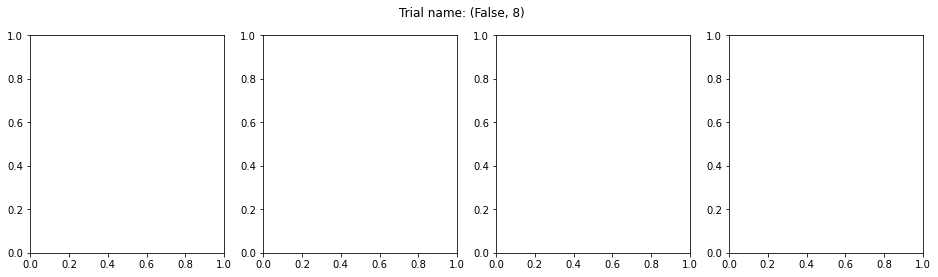

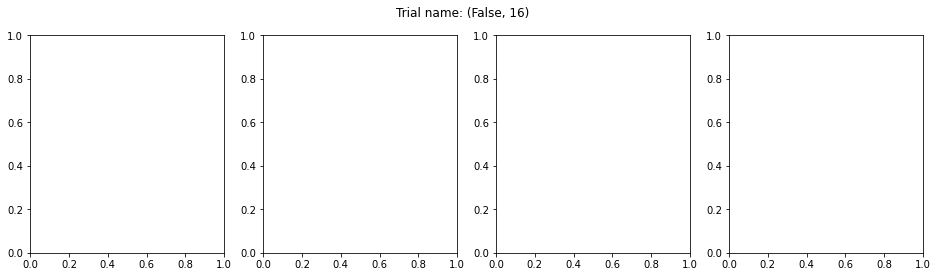

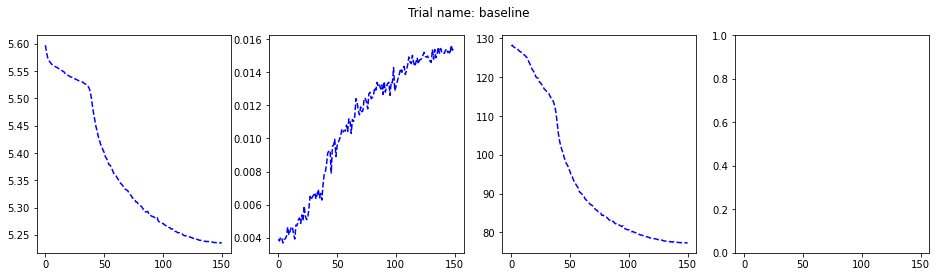

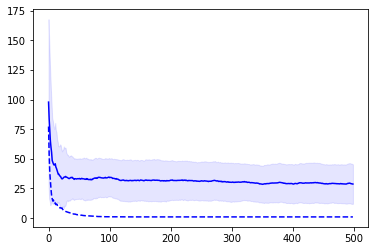

In [10]:
from training.metrics import get_rank_over_time

areas_under_curve = {}

for key in disc_train_results.keys():
    try:
        trial_train_results = disc_train_results[key]
        #trial_test_results = disc_test_results[key]
        fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True)
        fig.suptitle('Trial name: {}'.format(key))
        axes[0].plot([np.mean(x) for x in trial_train_results['loss']], color='blue', linestyle='--')
        #axes[0].plot([np.mean(x) for x in trial_test_results['loss']], color='blue', linestyle='-')
        axes[1].plot([np.mean(x) for x in trial_train_results['acc']], color='blue', linestyle='--')
        #axes[1].plot([np.mean(x) for x in trial_test_results['acc']], color='blue', linestyle='-')
        axes[2].plot([np.mean(x) for x in trial_train_results['mnrk']], color='blue', linestyle='--')
        #axes[2].plot([np.mean(x) for x in trial_test_results['mnrk']], color='blue', linestyle='-')
        #axes[3].plot([x[2] for x in trial_train_results['rot']], color='blue', linestyle='--')
        #axes[3].plot([x[2] for x in trial_test_results['rot']], color='blue', linestyle='-')
        plt.show()
    except:
        continue
    
    fig, ax = plt.subplots()
    if key == 'baseline':
        disc_model = torch.load(os.path.join(results_dir, 'trained_disc__baseline.pt'))
        gen_model = None
    else:
        hs, d = key
        disc_model = torch.load(os.path.join(results_dir, 'trained_disc__{}_{}.pt'.format(hs, d)))
        gen_model = torch.load(os.path.join(results_dir, 'trained_model__{}_{}.pt'.format(hs, d)))
    train_rot_mean, train_rot_std, _ = get_rank_over_time(train_dataloader, disc_model, generator=gen_model)
    test_rot_mean, test_rot_std, auc = get_rank_over_time(test_dataloader, disc_model, generator=gen_model)
    areas_under_curve[key] = auc
    ax.plot(train_rot_mean, color='blue', linestyle='--')
    ax.plot(test_rot_mean, color='blue', linestyle='-')
    ax.fill_between(np.arange(len(test_rot_mean)), test_rot_mean-test_rot_std, test_rot_mean+test_rot_std, color='blue', alpha=0.1)
    plt.show()

In [19]:
def test_epoch(model):
    results = execute_epoch(eval_batch, test_dataloader, model, nn.MSELoss(), 'cuda',
                            batch_metric_fns={'loss': get_loss}, autoencoder=True)
    return results

mse_values = {}
for realistic_hindsight in realistic_hindsight_values:
    mse_values[realistic_hindsight] = []
    for delay in delay_values:
        generator_model = torch.load(os.path.join(results_dir, 'trained_model__{}_{}.pt'.format(realistic_hindsight, delay)))
        loss_values = test_epoch(generator_model)['loss']
        mse_values[realistic_hindsight].append(np.mean(loss_values))
print(mse_values)

{True: [0.00013308797, 0.047982447, 0.072278306, 0.14816268, 0.19071764, 0.23029847], False: [0.0012988349, 0.04754175, 0.067678824, 0.14687853, 0.18327025, 0.22500637]}


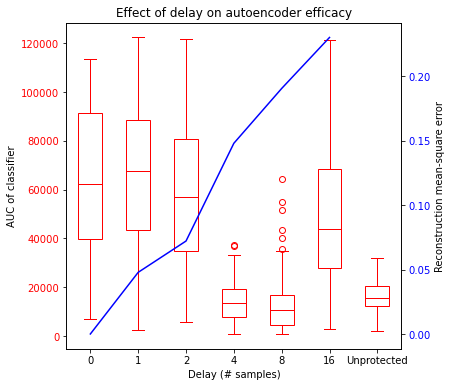

In [50]:
fig, ax = plt.subplots(figsize=(6, 6))
auc_data = len(areas_under_curve)*[None]
for key, item in areas_under_curve.items():
    if key == 'baseline':
        auc_data[-1] = item
    else:
        _, delay = key
        auc_data[delay_values.index(delay)] = item
tax = ax.twinx()
tax, ax = ax, tax
c = 'red'
tax.boxplot(auc_data, positions=np.arange(len(delay_values)+1), patch_artist=True,
            boxprops=dict(facecolor='none', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
#ax.plot(np.arange(len(delay_values)), mse_values[False], linestyle='--', color='blue', label='Oracle hindsight')
ax.plot(np.arange(len(delay_values)), mse_values[True], linestyle='-', color='blue', label='Realistic hindsight')
tax.set_xlabel('Delay (# samples)')
ax.set_ylabel('Reconstruction mean-square error')
ax.set_title('Effect of delay on autoencoder efficacy')
#ax.legend(loc='upper right')
ax.set_xticks(np.arange(len(delay_values)+1))
ax.set_xticklabels(delay_values + ['Unprotected'])
tax.set_ylabel('AUC of classifier')

for t in tax.yaxis.get_ticklines():
    t.set_color('red')
for t in ax.yaxis.get_ticklines():
    t.set_color('blue')
for t in tax.yaxis.get_ticklabels():
    t.set_color('red')
for t in ax.yaxis.get_ticklabels():
    t.set_color('blue')

['loss']


KeyError: (False, 0)

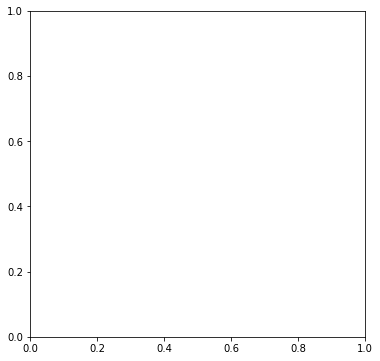

In [14]:
print([k for k in train_results.keys()])

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([np.min(train_results[(False, d)]['loss']) for d in delay_values], linestyle='--', color='blue', label='Oracle-train')
ax.plot([np.min(test_results[(False, d)]['loss']) for d in delay_values], linestyle='-', color='blue', label='Oracle-test')
ax.plot([np.min(train_results[(True, d)]['loss']) for d in delay_values], linestyle='--', color='red', label='Realistic-train')
ax.plot([np.min(test_results[(True, d)]['loss']) for d in delay_values], linestyle='-', color='red', label='Realistic-test')
ax.set_xlabel('Delay (# samples)')
ax.set_ylabel('Reconstruction mean-square error')
ax.set_title('Effect of delay on autoencoder efficacy')
ax.legend()
ax.set_xticks(np.arange(len(delay_values)))
ax.set_xticklabels(delay_values)

In [ ]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('plasma')
colors = [cmap(i/(len(delay_values)-1)) for i in range(len(delay_values))]
n_traces = 5
traces = next(iter(test_dataloader))[0][:n_traces]
for trace in traces:
    reconstructed_traces = {}
    for realistic_hindsight in [True]:
        for delay in delay_values:
            model = torch.load(os.path.join(results_dir, 'trained_model__{}_{}.pt'.format(realistic_hindsight, delay)))
            reconstructed_trace = model(trace.unsqueeze(0).cuda()).detach().squeeze().cpu().numpy()
            reconstructed_traces[(realistic_hindsight, delay)] = reconstructed_trace

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    trace = trace.squeeze().numpy()
    for delay, color in zip(delay_values[::-1], colors):
        reconstructed_trace = reconstructed_traces[(True, delay)]
        axes[0].plot(reconstructed_trace, label='Delay: {}'.format(delay), color=color)
        axes[1].plot(trace-reconstructed_trace, label='Delay: {}'.format(delay), color=color)
    axes[0].plot(trace, color='black', linestyle='--', label='Orig. trace')
    axes[1].plot(np.zeros_like(trace), color='black', linestyle='--', label='Orig. trace')
    axes[0].legend()
    axes[1].legend()
    axes[0].set_xlabel('Sample')
    axes[1].set_xlabel('Sample')
    axes[0].set_ylabel('Value')
    axes[1].set_ylabel('Value')
    axes[0].set_title('Reconstructed trace')
    axes[1].set_title('Difference from original trace')
    fig.suptitle('Case study: varying delay, realistic hindsight')

In [ ]:
with open(os.path.join(results_dir, 'delay_sweep.pickle'), 'rb') as F:
    test_losses = pickle.load(F)

print(test_losses)
    
plt.plot([np.min(test_losses[(False, d)]) for d in delay_values], color='blue', label='Oracle hindsight')
plt.plot([np.min(test_losses[(True, d)]) for d in delay_values], color='red', label='Realistic hindsight')
assert False

In [ ]:
model = LstmModel(delay=1, realistic_hindsight=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda'
model = model.to(device)

print('Model:', model)
print('Loss function:', loss_fn)
print('Optimizer:', optimizer)
print('Device:', device)